# Phishing email detection - Step 1
**Chloé MIGAUD**  

**Dataset:** [Kaggle — Phishing Email Dataset](https://www.kaggle.com/datasets/subhajournal/phishingemails)  
**Goal:** Make a first clean model to understand the data and see how well it can detect phishing emails.



In [11]:
# --- 0) Imports ---
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# --- 1) Descriptive analysis of the data ---
# Load of the dataset 
df = pd.read_csv("Phishing_Email.csv")

# We only kept the relevant columns and dropt missing values
df = df[['Email Text', 'Email Type']].dropna()

display(df.head())

# Basic info
print("\nDataset info:")
print(df.info())

# Class distribution
print("\nClass distribution:")
print(df['Email Type'].value_counts())

# Simple length statistic (to see how long are the emails)
df['text_len'] = df['Email Text'].str.len()
print("\nEmail length (chars):")
print(df['text_len'].describe())


,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email



Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 18634 entries, 0 to 18649
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  18634 non-null  object
 1   Email Type  18634 non-null  object
dtypes: object(2)
memory usage: 436.7+ KB
None

Class distribution:
Email Type
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64

Email length (chars):
count    1.863400e+04
mean     2.755654e+03
std      1.248677e+05
min      1.000000e+00
25%      4.040000e+02
50%      8.815000e+02
75%      1.880000e+03
max      1.703669e+07
Name: text_len, dtype: float64


=> I kept 2 main columns: Email Text (contains the raw message) and Email Type (Safe or Phishin). Then I removed missing values to make sure the dataset was clean.  
The class distribution shows there are more Safe Emails than Phishing Emails, this is common in this type of dataset.  

The text length varies a lot, some emails are very short, others extremely long. The dataset is quite diverse. This first look helps us understand the data and what to expect before moving to preprocessing and modeling.  

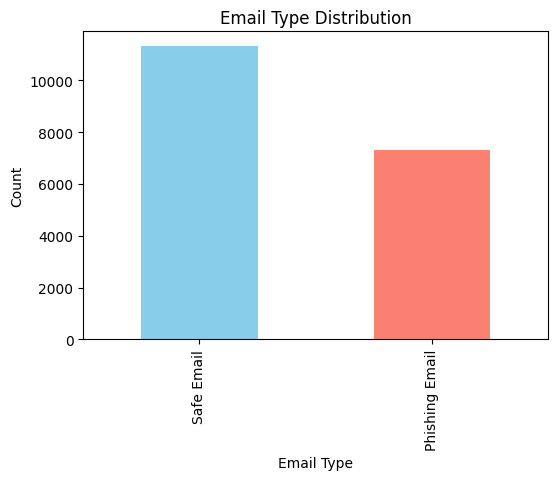

In [6]:
# Plot class distribution
plt.figure(figsize=(6,4))
df['Email Type'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title('Email Type Distribution')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

The bar chart shows that there are more Safe Emails than Phishing Emails. It also confirms that the dataset is a little bit unbalanced but still usable for training a model.

In [7]:
# --- 2) Necessary pre-processing ---
# Clean text: lowercase + remove special chars
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', ' url ', text)   # mark links
    text = re.sub(r'[^a-z\s]', ' ', text)     # keep letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # tidy spaces
    return text

df['clean_text'] = df['Email Text'].apply(clean_text)

# Encode labels: Safe -> 0, Phishing -> 1 
df['label'] = (df['Email Type'].str.lower().str.contains('phishing')).astype(int)

# Train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Fit on train, transform on test
# Convert text into numeric features so the model can learn from it
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train) # learn vocabulary from training set 
X_test_tfidf = vectorizer.transform(X_test)


I cleaned the text by removing special characters, links and converting everything to lowercase. Then I encoded the labels: Safe => 0 and Phishing => 1. I split the dataset into training and testing parts (80/20).  

Then I used TF-IDF to convert the emails into numbers so the model can learn from them.

**--- 3) Problem formalization ---**  
How can we automatically detect phishing emails using Machine Learning?  

The goal is to create a model that looks at the text of an email and predicts if it’s Safe or Phishing. This helps make email systems safer and protect users from scams.

So this is a supervised binary classification problem where the goal is to classify each email as Safe or Phishing based on its content.

In [9]:
# --- 4) Baseline model and evaluation ---
# Logistic Regression
model = LogisticRegression(max_iter=300)
model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_tfidf)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=['Safe', 'Phishing']))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))


Classification report:
              precision    recall  f1-score   support

        Safe       0.97      0.96      0.97      2265
    Phishing       0.94      0.96      0.95      1462

    accuracy                           0.96      3727
   macro avg       0.96      0.96      0.96      3727
weighted avg       0.96      0.96      0.96      3727


Confusion matrix:
[[2176   89]
 [  56 1406]]


The Logistic Regression model performed well. I got an accuracy of around 96%, which means the model correctly classified most emails. Precision is high for both classes, that means it rarely mislabels a Safe email as Phishing.  

Recall for Phishing (0.96) is very good, so the model catches most fraudulent emails.  

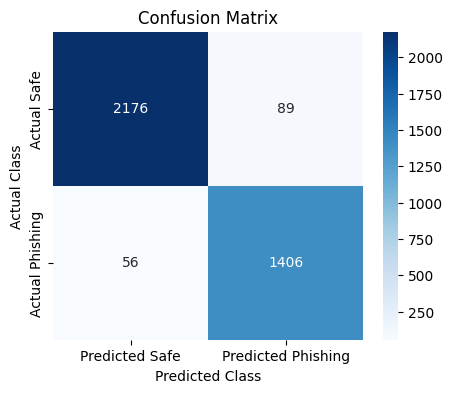

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Safe', 'Predicted Phishing'],
            yticklabels=['Actual Safe', 'Actual Phishing'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

The confusion matrix shows only a few mistakes, some phishing emails are still predicted as Safe, but very few